<a href="https://colab.research.google.com/github/ldselvera/Fraud_Detectiong_Deep_Learning/blob/main/Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam

from keras import regularizers, optimizers
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Conv1D, Dense, Flatten, Activation, UpSampling1D, MaxPooling1D, ZeroPadding1D
from keras.layers import Flatten, Dropout, BatchNormalization, MaxPool1D

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn import datasets, decomposition, preprocessing

from mpl_toolkits.mplot3d import Axes3D

print(tf.__version__)

2.4.1


## Dataset

In [ ]:
#import dataset from csv
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/fraud/creditcard.csv")

In [ ]:
#preview of the data
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

### Check for missing values (Null/NaN)

In [ ]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

### Imbalanced data

In [ ]:
# Number of instances per class 
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [ ]:
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


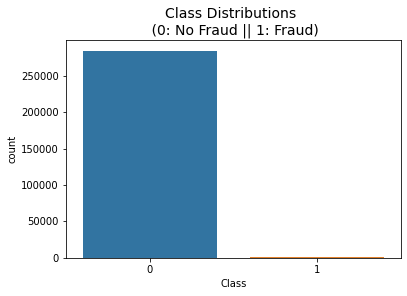

In [ ]:
sns.countplot('Class', data=df)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)
plt.show()

In [ ]:
def show_pca_df(df):
	x = df[df.columns[1:30]].to_numpy()
	y = df[df.columns[30]].to_numpy()

	x = preprocessing.MinMaxScaler().fit_transform(x)
	pca = decomposition.PCA(n_components=3)
	pca_result = pca.fit_transform(x)
	print(pca.explained_variance_ratio_)

	pca_df = pd.DataFrame(data=pca_result, columns=['pc_1', 'pc_2', 'pc_3'])
	pca_df = pd.concat([pca_df, pd.DataFrame({'label': y})], axis=1)

	ax = Axes3D(plt.figure(figsize=(8, 8)))
	ax.scatter(xs=pca_df['pc_1'], ys=pca_df['pc_2'], zs=pca_df['pc_3'], c=pca_df['label'], s=25)
	ax.set_xlabel("pc_1")
	ax.set_ylabel("pc_2")
	ax.set_zlabel("pc_3")
	plt.show()

[0.13501016 0.12577773 0.12031403]


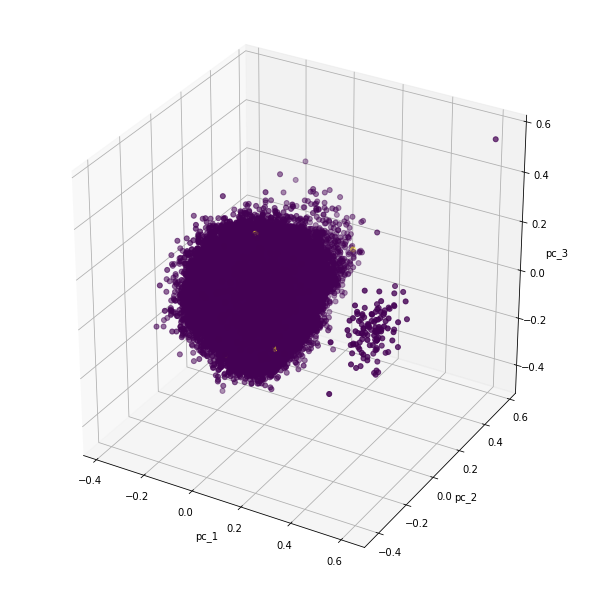

In [ ]:
show_pca_df(df)

### Subsampling

In [ ]:
#Split fraud and normal transactions
fraud_data = df[df['Class']==1]
non_fraud_data = df[df["Class"]==0]

#Subsample according to the size of fraud transactions
non_fraud_data1 = non_fraud_data.sample(1500)

#Rejoin fraud and normal transactions
final_data = fraud_data.append(non_fraud_data1,ignore_index=True)


In [ ]:
print('No Frauds', round(final_data['Class'].value_counts()[0]/len(final_data) * 100,2), '% of the dataset')
print('Frauds', round(final_data['Class'].value_counts()[1]/len(final_data) * 100,2), '% of the dataset')

No Frauds 75.3 % of the dataset
Frauds 24.7 % of the dataset


Distribution of the Classes in the subsample dataset
0    0.753012
1    0.246988
Name: Class, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


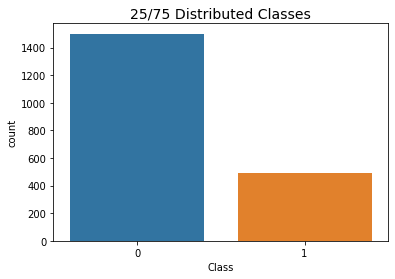

In [ ]:
print('Distribution of the Classes in the subsample dataset')
print(final_data['Class'].value_counts()/len(final_data))

sns.countplot('Class', data=final_data)
plt.title('25/75 Distributed Classes', fontsize=14)
plt.show()

In [ ]:
final_data['Class'].value_counts()

0    1500
1     492
Name: Class, dtype: int64

[0.20577961 0.14728955 0.09800457]


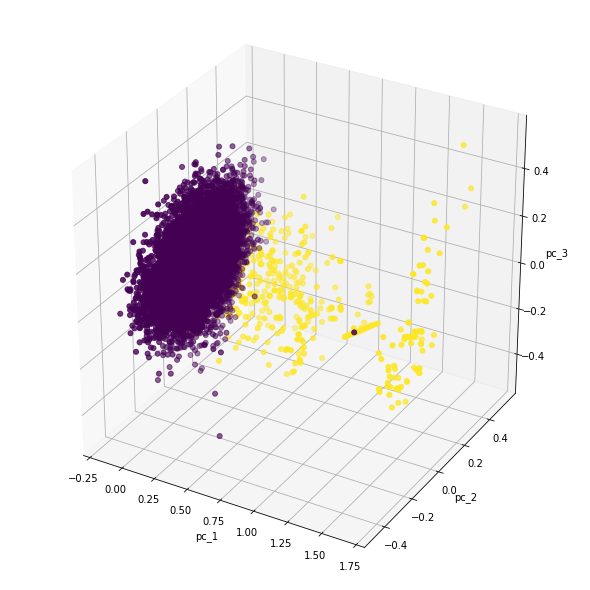

In [ ]:
df_anomaly = df[df[df.columns[30]] > 0]
df_normal = df[df[df.columns[30]] == 0].sample(n=df_anomaly.size, random_state=1, axis='index')
df = pd.concat([ df_anomaly, df_normal])

show_pca_df(df)

## Normalize Data

In [ ]:
df['Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))
df['Time'] = StandardScaler().fit_transform(df['Time'].values.reshape(-1, 1))

## Splitting Data

In [ ]:
anomalies = df[df["Class"] == 1]
normal = df[df["Class"] == 0]

anomalies.shape, normal.shape

((492, 31), (15252, 31))

In [ ]:
data_set = pd.concat([normal[:1500], anomalies])

x_train, x_test = train_test_split(data_set, test_size = 0.2)

x_train = x_train.sort_values(by=['Time'])
x_test = x_test.sort_values(by=['Time'])

y_train = x_train["Class"]
y_test = x_test["Class"]

x_train.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
229,-1.979329,-0.903628,-0.233363,2.580864,-0.990572,-0.397920,0.281755,0.238619,0.249102,0.651330,-0.881775,0.939972,0.397779,-1.494563,-0.428434,-1.307942,-0.095618,-0.080170,-0.432193,-0.336658,0.050471,-0.075017,-0.097906,0.059448,0.244548,-0.316141,0.754405,-0.166316,-0.138177,-0.082732,0
258,-1.978741,1.136752,-0.103770,0.904686,0.488211,-0.678524,0.039861,-0.581294,0.270996,0.256540,0.068092,1.445184,0.506268,-0.850215,0.464223,0.963247,0.522012,-0.463008,0.029022,-0.386661,-0.166087,-0.017527,-0.093159,0.119723,-0.000588,0.026252,0.229223,0.000201,0.010945,-0.343345,0
482,-1.975090,0.019256,0.471698,0.868060,-1.239124,0.547898,-0.502661,0.808516,-0.247667,0.130741,-0.484994,-0.702094,-0.213445,-0.048713,-0.065307,0.658810,0.168526,-0.621304,-0.690750,-0.697036,-0.107130,0.021430,0.265057,0.066608,-0.381752,-1.305171,0.646049,-0.013625,-0.011985,-0.358872,0
615,-1.972824,-0.634597,0.866354,1.123836,-0.304041,1.173910,0.257118,0.754325,0.171735,-0.825981,-0.531058,0.549389,0.598609,0.313814,0.354548,-0.156778,0.328551,-0.983933,0.235906,-0.630728,-0.105239,0.160463,0.422873,-0.353721,-0.847192,0.206896,-0.436112,0.110134,0.102261,-0.365348,0
623,-1.972636,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,-0.838587,-0.414575,-0.503141,0.676502,-1.692029,2.000635,0.666780,0.599717,1.725321,0.283345,2.102339,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,1.758493,1
958,-1.967327,-0.534913,0.550684,4.017561,3.254904,-0.919559,1.644716,-0.638287,0.432396,0.000158,0.501195,0.446254,1.052726,0.451786,-1.402749,-1.870148,-0.619166,0.436713,0.612061,1.522573,0.247874,0.147772,1.096225,-0.416073,0.628186,0.106290,0.474381,0.019260,-0.126126,-0.366313,0
1225,-1.962711,0.904759,-0.518302,0.398305,0.495653,-0.834514,-0.642216,0.044820,-0.043259,0.223597,-0.119216,1.299905,0.849929,-0.691546,0.411388,-0.333285,0.082616,-0.214906,-0.157369,0.400149,0.175592,-0.096473,-0.576288,-0.051439,0.572083,0.192744,0.400686,-0.079651,0.027963,0.266173,0
1300,-1.961137,0.414441,-0.957193,-0.277388,1.707264,-0.533226,-0.690275,0.924293,-0.381707,-0.089759,-0.221693,-0.529581,0.657116,0.562364,0.223669,-0.024087,-0.348942,-0.134683,-0.426564,-0.270321,0.743023,0.231007,-0.114463,-0.530896,0.452978,0.703282,-0.308887,-0.067590,0.089635,1.364295,0
1569,-1.956773,-0.693097,0.720897,0.487926,1.545283,-0.123343,0.151906,1.821822,-0.176592,-1.514396,-0.581211,1.491590,0.523781,0.824358,-0.591794,0.879726,-0.158535,0.702919,1.172998,1.713201,0.846036,0.200782,0.193611,0.288196,-0.081502,0.281742,-0.136080,0.050083,0.147487,0.756627,0
1595,-1.956479,-1.934514,0.398684,-0.676379,-2.270048,-0.761439,-0.591461,0.717055,0.778131,0.259545,-1.452593,1.010168,1.092521,-0.336543,1.188112,0.624403,-0.409664,0.058323,0.111844,0.634837,-0.052783,0.119474,0.422229,0.277076,-0.259721,0.024995,-0.080820,0.399133,-0.133506,0.274218,0


In [ ]:
x_train = np.array(x_train).reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = np.array(x_test).reshape(x_test.shape[0], x_test.shape[1], 1)
input_shape = (x_train.shape[1], 1)

y_train = keras.utils.to_categorical(y_train, 2)
y_test = keras.utils.to_categorical(y_test, 2)

print("Shapes:\nx_train:%s\ny_train:%s\n" % (x_train.shape, y_train.shape))
print("x_test:%s\ny_test:%s\n" % (x_test.shape, y_test.shape))
print("input_shape:{}\n".format(input_shape))

Shapes:
x_train:(1593, 31, 1)
y_train:(1593, 2)

x_test:(399, 31, 1)
y_test:(399, 2)

input_shape:(31, 1)



In [ ]:
y_train[:5]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

## Build Model

In [ ]:
input_layer = Input(shape=(input_shape ))

# ENCODING STAGE

#filters: the dimensionality of the output space
#kernel size: the length of the 1D convolution window
#dilation rate: dilation rate to use for dilated convolution
#padding: causal (dilated) convolutions, useful when modeling temporal data where the model should not violate the temporal order
#strides: the stride length of the convolution
#kernel regularizer: The L2 regularization penalty is computed as: loss = l2 * reduce_sum(square(x))
#activation ReLU: the rectified linear unit activation function
#this returns the standard ReLU activation: max(x, 0)

conv_1 = Conv1D(filters=int(input_shape[0]), kernel_size=2, dilation_rate=1,
                padding='causal', strides=1,input_shape=input_shape,
                kernel_regularizer=regularizers.l2(0.01),
                activation='relu')(input_layer)

pool_1 = MaxPooling1D(pool_size=2, strides=2)(conv_1)

conv_2 = Conv1D(filters=int(input_shape[0] / 2), kernel_size=2, dilation_rate=1,
                padding='causal',strides=1, 
                kernel_regularizer=regularizers.l2(0.01),
                activation='relu')(pool_1)           

pool_2 = MaxPooling1D(pool_size=2, strides=3)(conv_2)

conv_3 = Conv1D(filters=int(input_shape[0] / 3), kernel_size=2, dilation_rate=1,
                padding='causal', strides=1,
                kernel_regularizer=regularizers.l2(0.01),
                activation='relu')(pool_2)


# OUTPUT OF ENCODING STAGE
encoder = Dense(int(input_shape[0] / 6), activation='relu')(conv_3)

# DECODING STAGE
upsample_1 = UpSampling1D(size=3)(encoder)

conv_4 = Conv1D(filters=int(input_shape[0]/3), kernel_size=2, dilation_rate=1,
                padding='causal',strides=1, 
                kernel_regularizer=regularizers.l2(0.01),
                activation='relu')(upsample_1)

upsample_2 = UpSampling1D(size=2)(conv_4)

conv_5 = Conv1D(filters=int(input_shape[0]/2), kernel_size=2, dilation_rate=1,
                padding='causal', strides=1,
                kernel_regularizer=regularizers.l2(0.05),
                activation='relu')(upsample_2)

zero_pad_1 = ZeroPadding1D(padding=(0,1))(conv_5)

conv_6 = Conv1D(filters=int(input_shape[0]), kernel_size=2, dilation_rate=1,
                padding='causal', strides=1,
                kernel_regularizer=regularizers.l2(0.05),
                activation='relu')(zero_pad_1)


# Output of decoding stage flattened
flat = Flatten()(conv_6)

#softmax to make predictions
output_layer = Dense(2, activation='softmax')(flat)

model = Model(inputs=input_layer, outputs=output_layer)

In [ ]:
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=optimizers.Adam(lr=0.002), metrics=["accuracy"])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 31, 1)]           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 31, 31)            93        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 15, 31)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 15, 15)            945       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5, 15)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 5, 10)             310       
_________________________________________________________________
dense (Dense)                (None, 5, 5)              55    

## Training

In [ ]:
history = model.fit(x_train, y_train, epochs=25, verbose=1, validation_data=(x_test, y_test))

Epoch 1/25
50/50 [==============================] - 3s 23ms/step - loss: 2.1485 - accuracy: 0.7780 - val_loss: 0.8868 - val_accuracy: 0.9649
Epoch 2/25
50/50 [==============================] - 0s 10ms/step - loss: 0.7780 - accuracy: 0.9545 - val_loss: 0.4606 - val_accuracy: 0.9724
Epoch 3/25
50/50 [==============================] - 0s 10ms/step - loss: 0.4492 - accuracy: 0.9532 - val_loss: 0.3018 - val_accuracy: 0.9649
Epoch 4/25
50/50 [==============================] - 0s 9ms/step - loss: 0.3241 - accuracy: 0.9545 - val_loss: 0.2478 - val_accuracy: 0.9699
Epoch 5/25
50/50 [==============================] - 0s 10ms/step - loss: 0.2718 - accuracy: 0.9557 - val_loss: 0.2246 - val_accuracy: 0.9674
Epoch 6/25
50/50 [==============================] - 0s 9ms/step - loss: 0.2591 - accuracy: 0.9531 - val_loss: 0.1904 - val_accuracy: 0.9699
Epoch 7/25
50/50 [==============================] - 0s 9ms/step - loss: 0.2178 - accuracy: 0.9574 - val_loss: 0.1811 - val_accuracy: 0.9699
Epoch 8/25
50/50

## Results

In [ ]:
def plot_learning_curve(history,epochs):
    
    epoch_range=range(1,epochs+1)
    plt.plot(epoch_range,history.history['accuracy'])
    plt.plot(epoch_range,history.history["val_accuracy"])
    plt.title("Model Accuracy")
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.legend("train","val",loc="upper left")
    plt.show()
     
    plt.plot(epoch_range,history.history['loss'])
    plt.plot(epoch_range,history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Train','Val'],loc='upper left')
    plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Legend does not support 't' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Legend does not support 'a' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  if __name__ == '__main__':


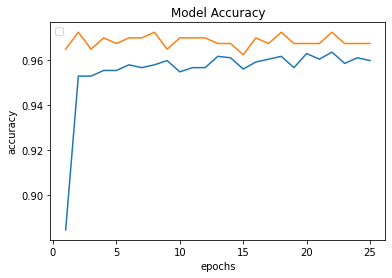

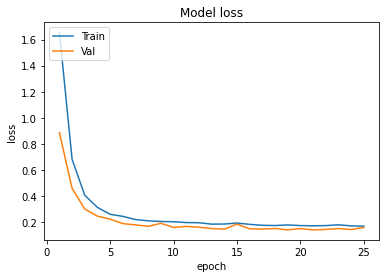

In [ ]:
plot_learning_curve(history, 25)

In [ ]:
final_acc = model.evaluate(x_train,y_train, verbose=0)
print('Test loss:', final_acc[0])
print('Test accuracy:', final_acc[1])

Test loss: 0.17682461440563202
Test accuracy: 0.9560577273368835


In [ ]:
preds = model.predict(x_test)
y_pred = np.round(preds)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       306
           1       0.94      0.91      0.93        93

   micro avg       0.97      0.97      0.97       399
   macro avg       0.96      0.95      0.95       399
weighted avg       0.97      0.97      0.97       399
 samples avg       0.97      0.97      0.97       399



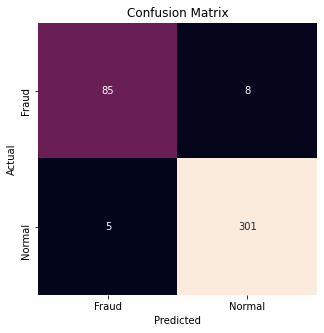

In [ ]:
labels = ["Fraud", "Normal"]

y_pred2 = np.argmax(y_pred, axis=1)
y_test2 = np.argmax(y_test, axis=1)

matrix = np.flip(confusion_matrix(y_test2, y_pred2))

plt.figure(figsize=(5, 5))
sns.heatmap(matrix, xticklabels=labels, yticklabels=labels,  annot=True, fmt="d", cbar=False)
plt.title("Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()